# Data download & Data preprocess

In [1]:
! bash preprocess.sh

--2020-11-15 06:18:00--  http://statmt.org/europarl/v7/de-en.tgz
Resolving statmt.org (statmt.org)... 129.215.197.184
Connecting to statmt.org (statmt.org)|129.215.197.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 197785698 (189M) [application/x-gzip]
Saving to: ‘./data/de-en.tgz’

de-en.tgz           100%[===================>] 188.62M  2.30MB/s    in 1m 57s  

2020-11-15 06:19:58 (1.61 MB/s) - ‘./data/de-en.tgz’ saved [197785698/197785698]

europarl-v7.de-en.de
europarl-v7.de-en.en
DeEn/
DeEn/alignmentDeEn
DeEn/alignmentDeEn.talp
DeEn/en
DeEn/de
tokenizing by moses tokenizer...
removing sentences appeared in test data from train data & lowercasing...
removed 1671 sentences from train data
training BPE models...
/sentencepiece/src/sentencepiece_trainer.cc(185) LOG(INFO) Running command: --input_sentence_size=100000000 --model_prefix=./work/bpe_model_and_vocab/de --model_type=bpe --num_threads=4 --split_by_unicode_script=1 --split_by_whitespace=1  --remove

# Training Transformer NMT models (5 seeds)

Training uses 2 GPUs

In [ ]:
! bash train.sh

# Calculate AER
If you want to check visualization results, see `results` directory

In [3]:
!python calculate_aer.py

seed:  2253
--------------- Alignmen with output (AWO) setting ---------------
layer mean:
	Attention weight:			 67.43788251577455
	Our norm:				 62.321652278497254
best layer:
	Attention weight:	 layer 5 	 45.17630212994451
	Our norm:		 layer 5 	 39.76687859521647
layer with the highest average norm:
	Our norm:	 	layer 2 	 82.10372901799175
head with the highest average norm:
	Our norm:	 layer 1 head 4 	 88.84014831061674
correlation with averaged norm:
	Spearman's ρ:				 0.45652173913043476
	Pearson's r:				 0.47434073025779006
--------------- Alignmen with input (AWI) setting ---------------
layer mean:
	Attention weight:			 67.17286128348012
	Our norm:				 58.28834082678176
best layer:
	Attention weight:	 layer 2 	 30.25437289631959
	Our norm:		 layer 2 	 25.35083748302399
layer with the highest average norm:
	Our norm:	 	layer 2 	 25.35083748302399
head with the highest average norm:
	Our norm:	 layer 1 head 4 	 23.563248444281758
correlation with averaged norm:
	Spearman's ρ:				

# Visualize attention pattern

In [4]:
from calculate_aer import *
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def visualize_attn_pattern(layer, idx, seed, hard=False):
    '''
    Given a layer (as a integer), an index of test sample (as a integer), 
    amd a seed (as a integer), visualize attention pattern by attention weights and vector norms.
    
    Args:
        layer: integer (0~5)
        idx: integer (0~507)
        seed: integer (2253, 5498, 9819, 9240, 2453)
        hard: boolean
    '''
    
    with open('./work/results_seed'+str(seed)+'/alignments/extracted_matrix.pkl', 'rb') as f:
        extract_matrix = pickle.load(f)

    with open("./work/processed_data/test.bpe.de", encoding="utf-8") as fbpe:
        src_bpe_sents = fbpe.readlines()
    with open("./work/data_in_progress/test.uc.de", encoding="utf-8") as fword:
        src_word_sents = fword.readlines()

    with open("./work/processed_data/test.bpe.en", encoding="utf-8") as fbpe:
        tgt_bpe_sents = fbpe.readlines()
    with open("./work/data_in_progress/test.uc.en", encoding="utf-8") as fword:
        tgt_word_sents = fword.readlines()

    src_bpe_sent = src_bpe_sents[idx]
    src_word_sent = src_word_sents[idx]
    src_word_to_bpe = convert_bpe_word(src_bpe_sent, src_word_sent)

    tgt_bpe_sent = tgt_bpe_sents[idx]
    tgt_word_sent = tgt_word_sents[idx]
    tgt_word_to_bpe = convert_bpe_word(tgt_bpe_sent, tgt_word_sent)
        
    if hard:
        modes = ["attn", "summed_afx", "gold"]
    else:
        modes = ["attn", "summed_afx"]
    
    for mode in modes:
        print("\t"+mode+":")
        if mode == "attn":
            attention_matrix = torch.squeeze(extract_matrix[idx][mode][layer]).mean(0).detach().numpy()
        else:
            attention_matrix = torch.squeeze(extract_matrix[idx]["summed_afx"][layer]).detach().numpy()
        attention_matrix = get_word_word_attention(attention_matrix, src_word_to_bpe, tgt_word_to_bpe, remove_EOS=False)
        
        if hard:
            a_argmax = np.argmax(attention_matrix, -1)

            attention_matrix = np.zeros(attention_matrix.shape)

            if mode == "gold":
                with open("./work/gold_alignment/alignment.talp", 'r') as f:
                    line = f.readlines()[idx]
                    for alignment_string in line.split():
                        t, s = parse_single_alignment(alignment_string, reverse=True)
                        attention_matrix[t-1][s-1] = 1
                attention_matrix = attention_matrix[[len(attention_matrix)-1]+list(range(0,len(attention_matrix)-1))]
            else:
                for i, j in enumerate(a_argmax):
                    attention_matrix[i][j] = 1
        
        plt.figure(figsize=(3,3), dpi=300)
        df = pd.DataFrame(attention_matrix, columns=src_word_sent.split()+["</s>"],index=["</s>"]+tgt_word_sent.split())
        sns.heatmap(df,cmap="Reds",cbar=False,square=True)
        plt.gcf().subplots_adjust(bottom=0.4)
        plt.gcf().subplots_adjust(left=0.3)
        plt.show()

layer 1
	attn:


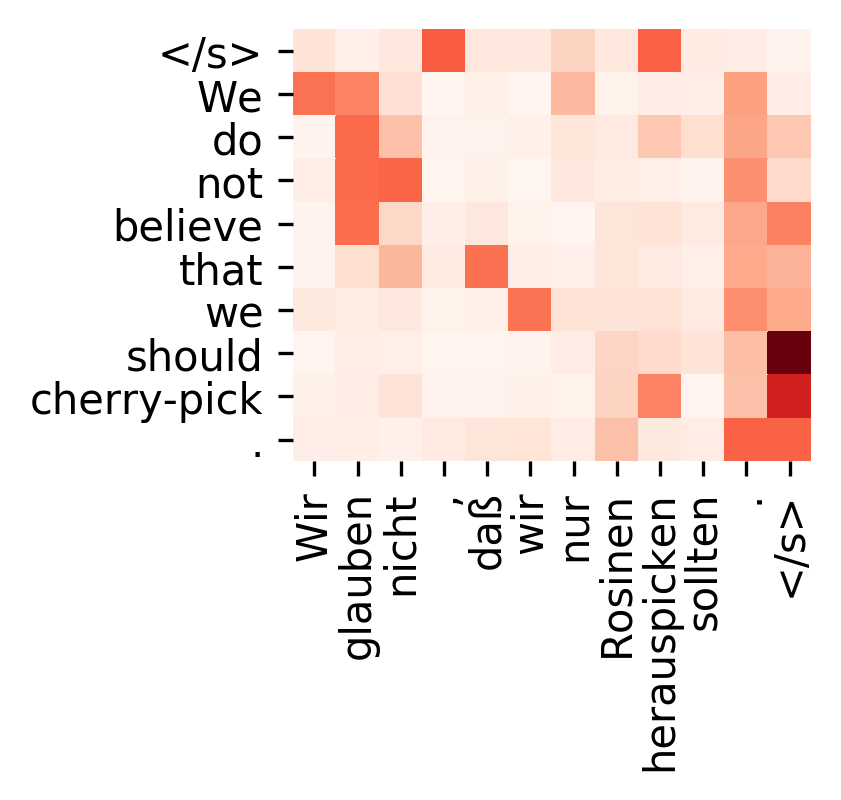

	summed_afx:


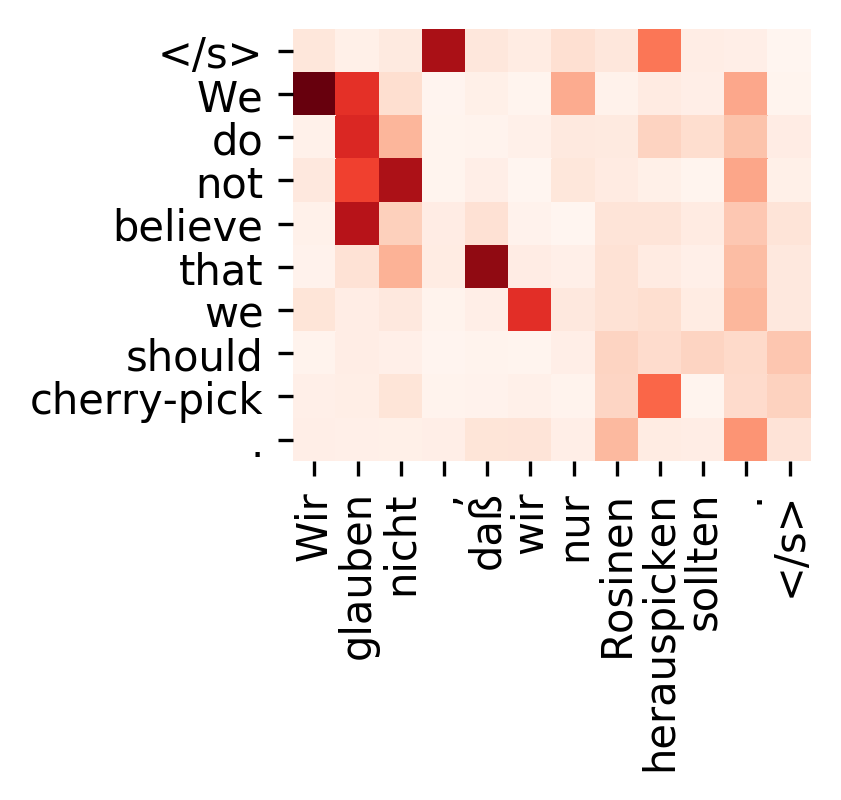

	attn:


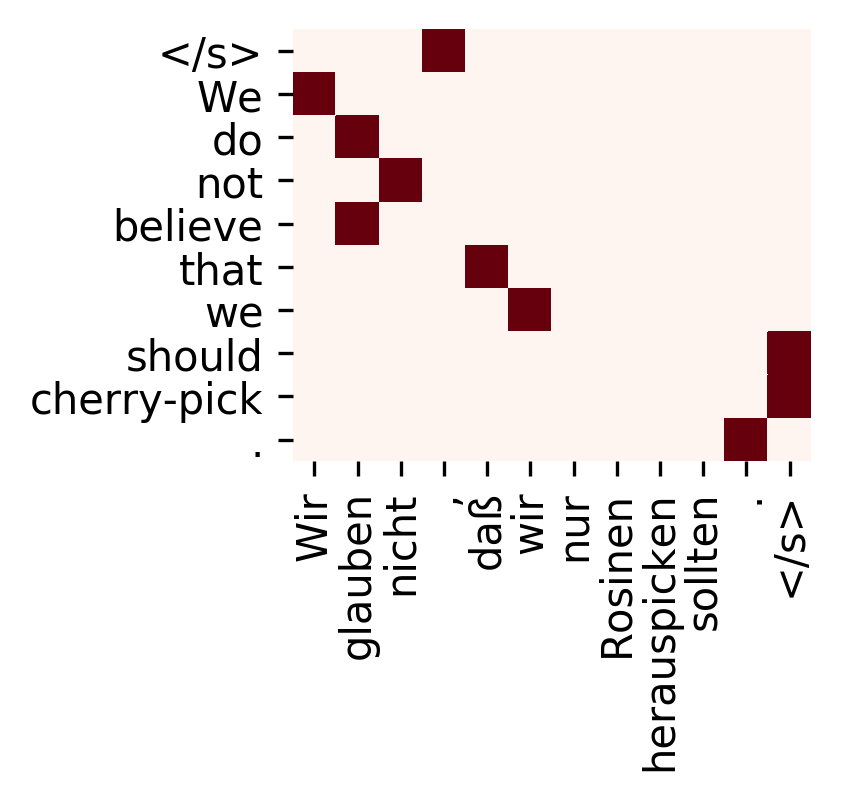

	summed_afx:


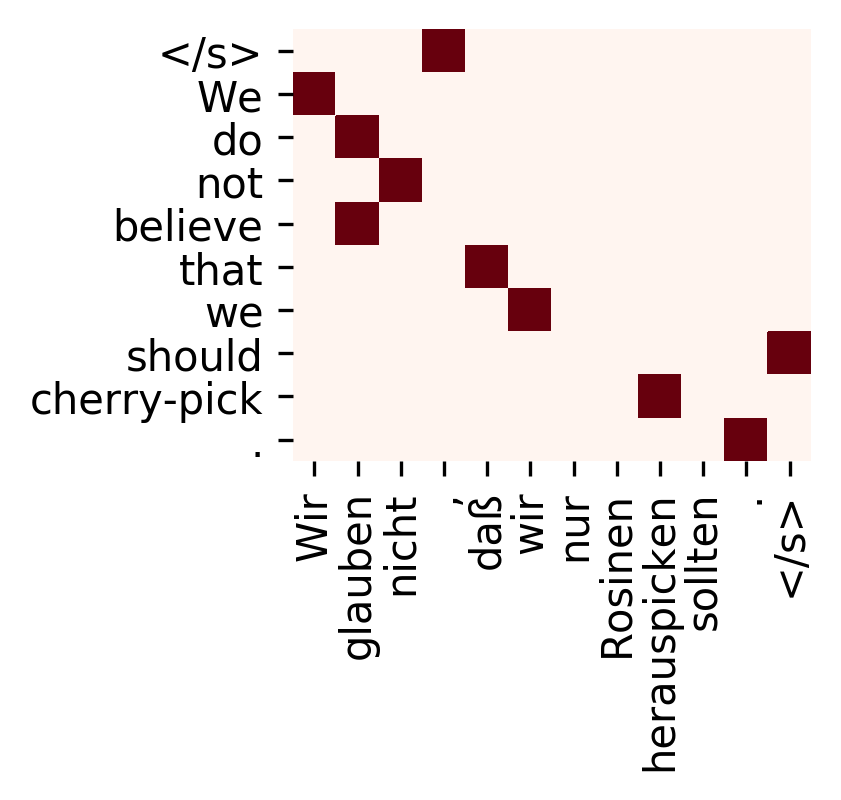

	gold:


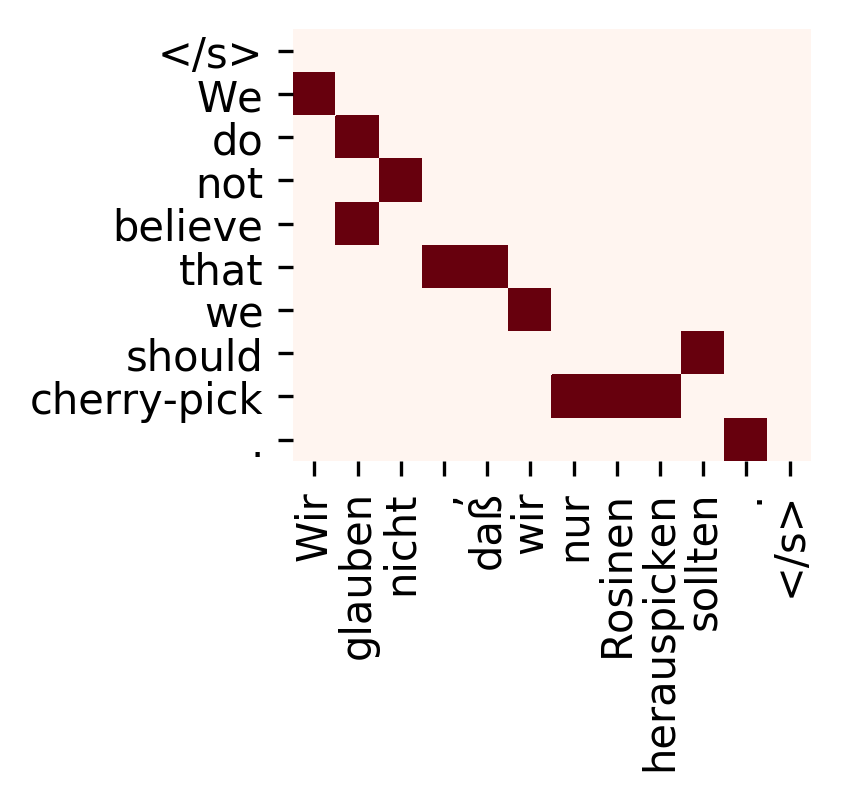

layer 2
	attn:


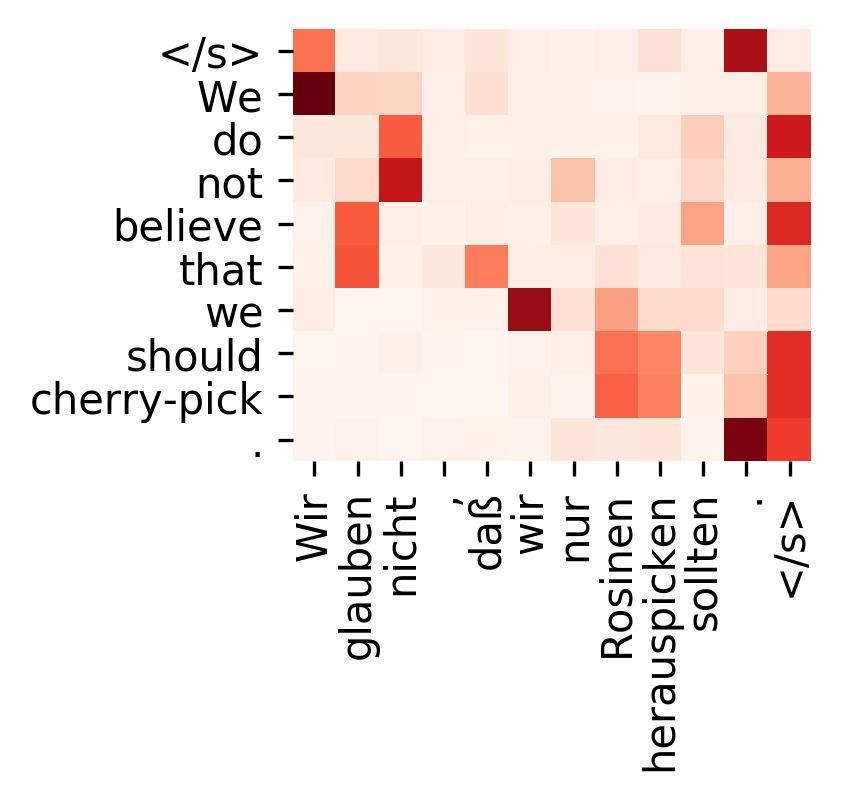

	summed_afx:


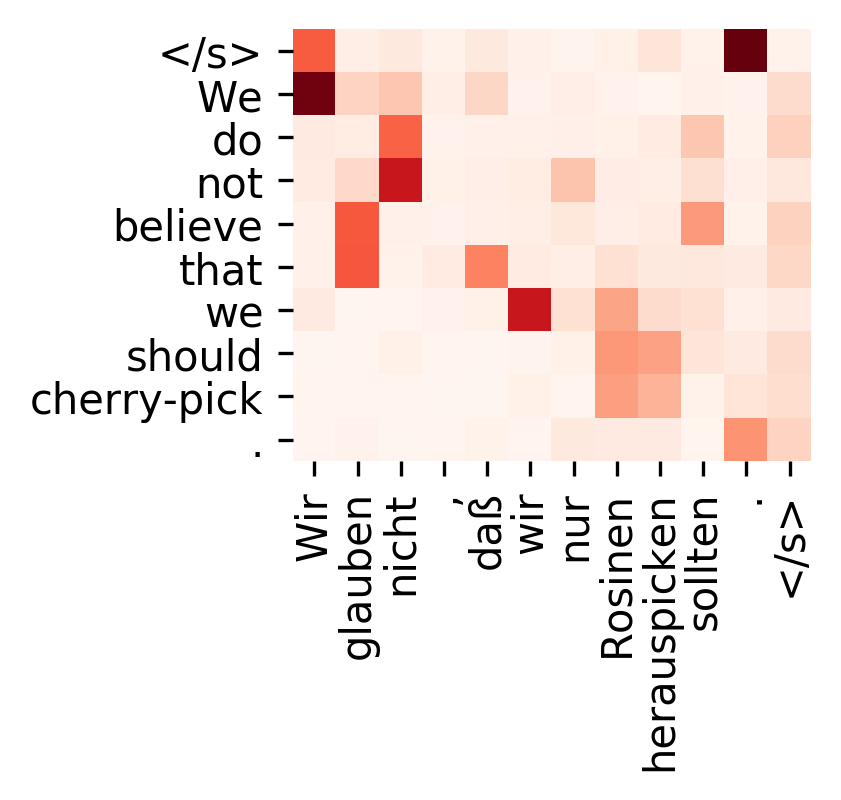

	attn:


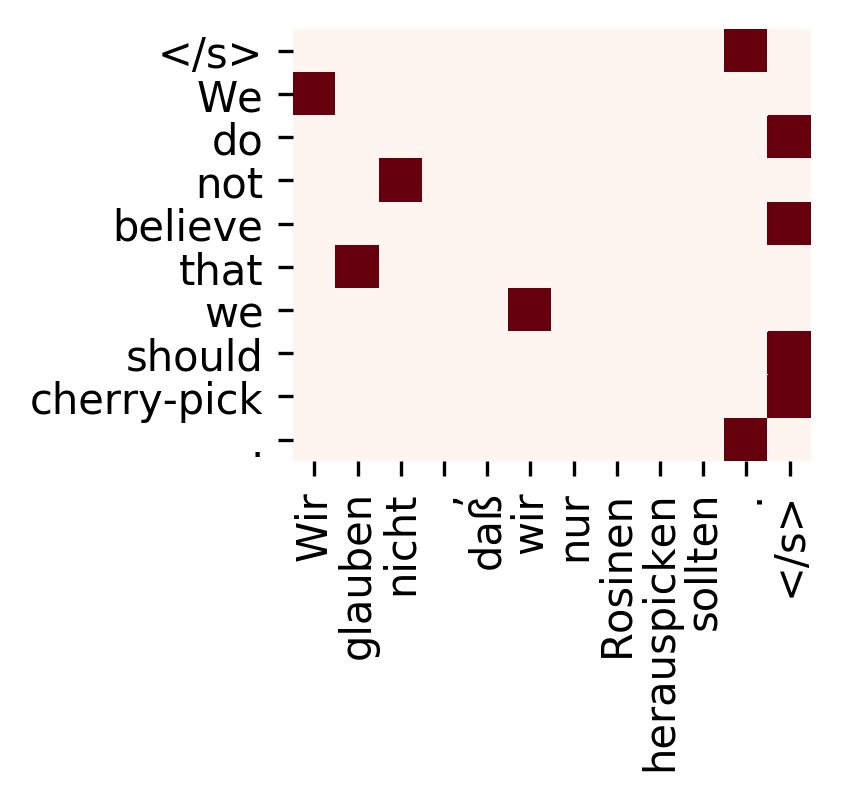

	summed_afx:


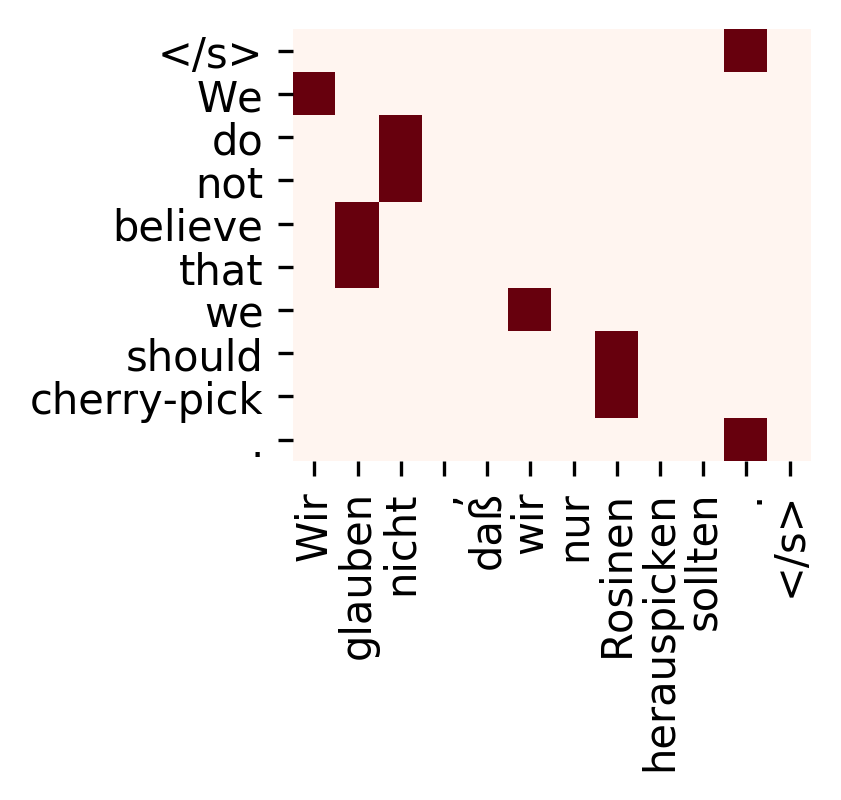

	gold:


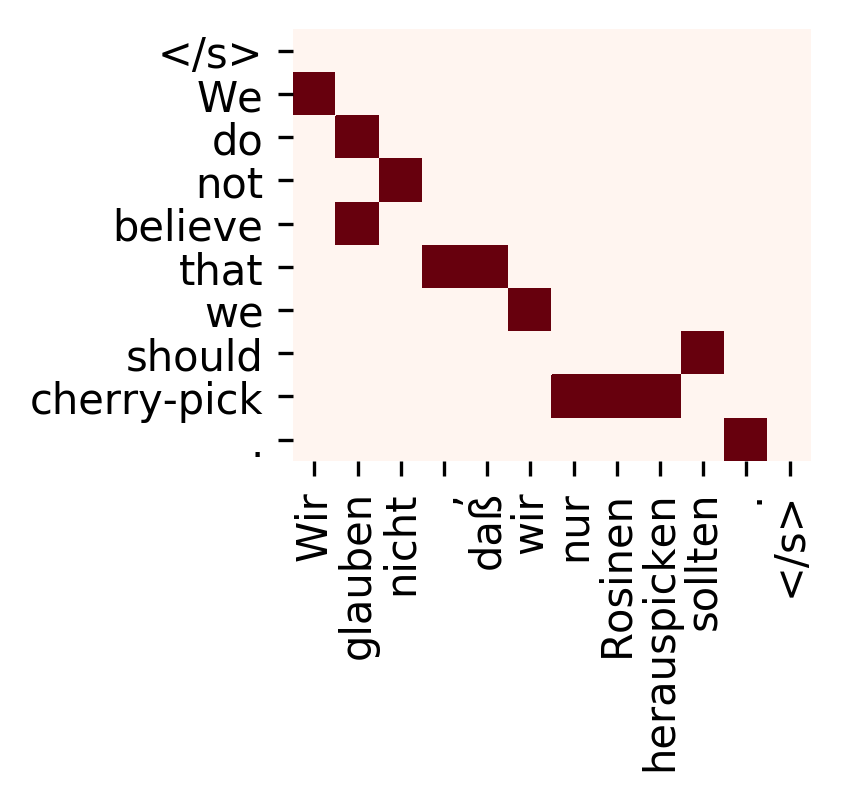

layer 3
	attn:


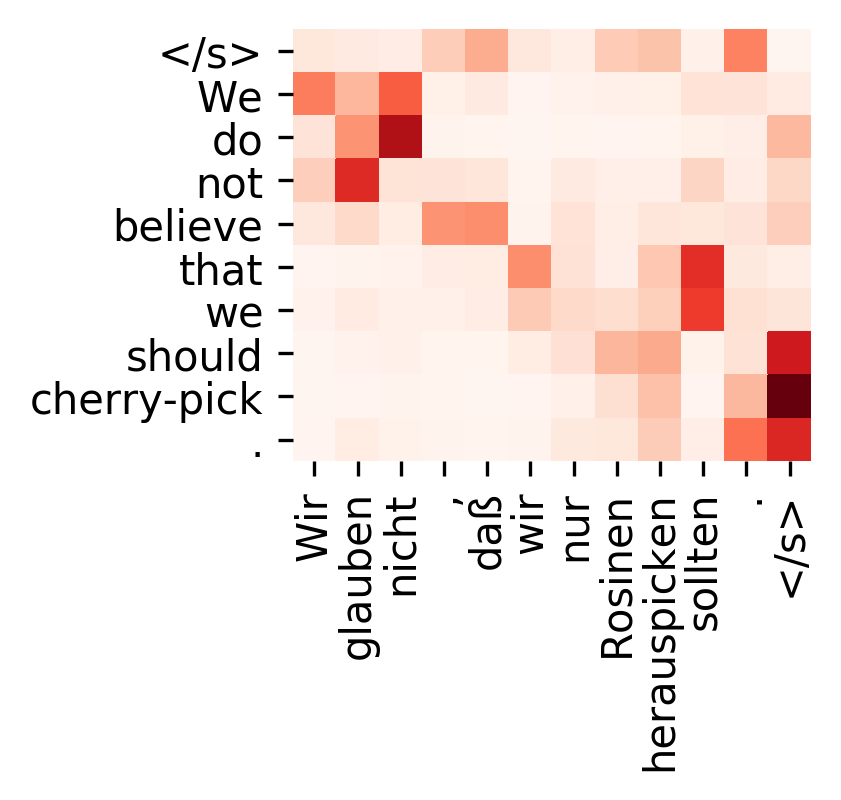

	summed_afx:


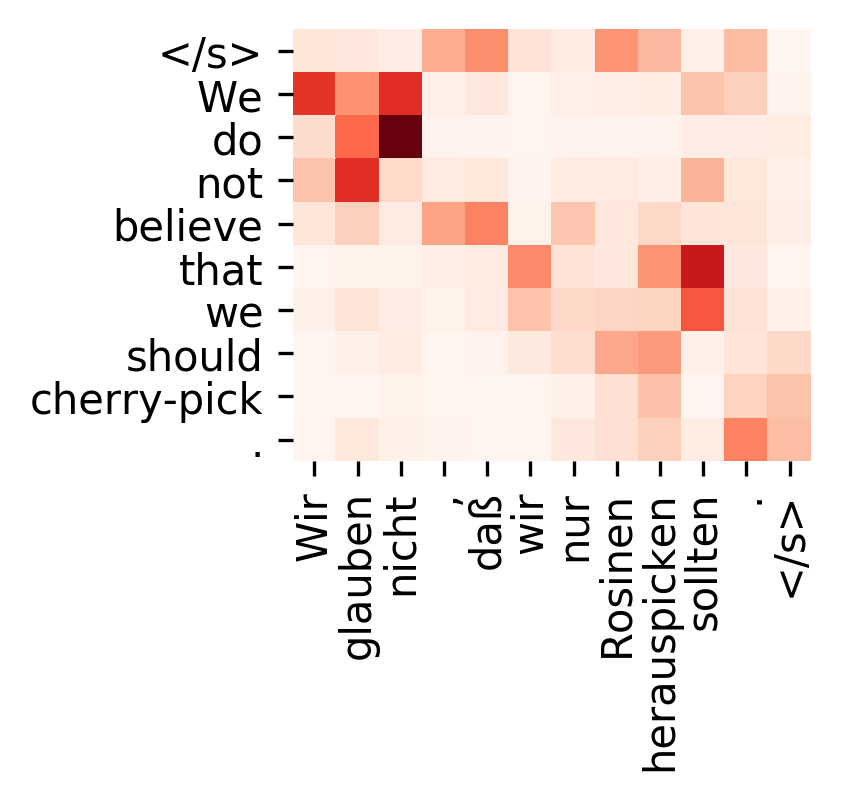

	attn:


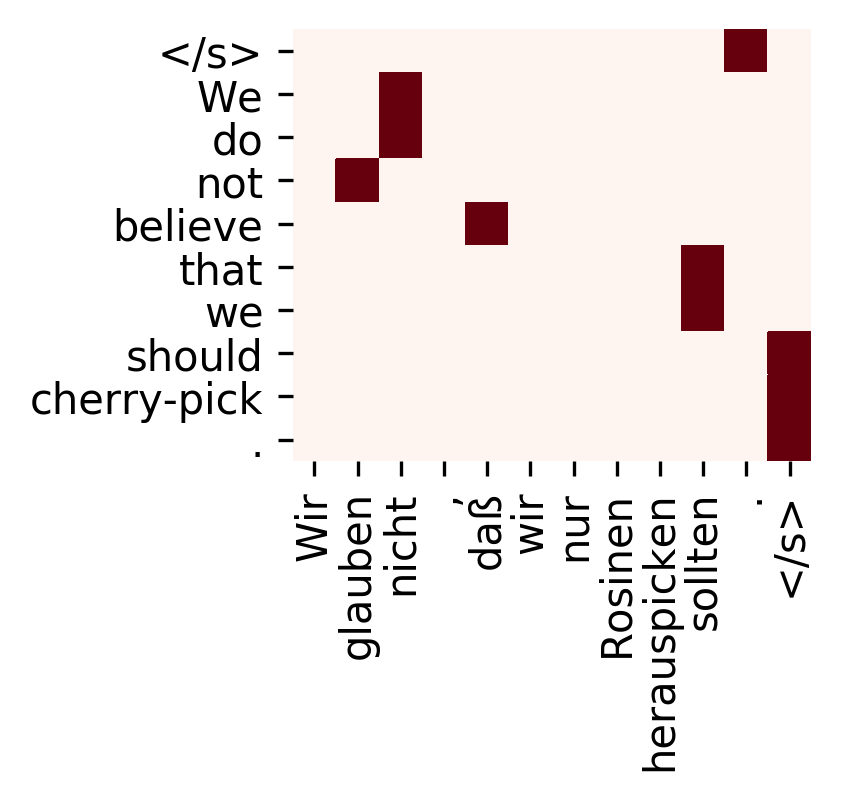

	summed_afx:


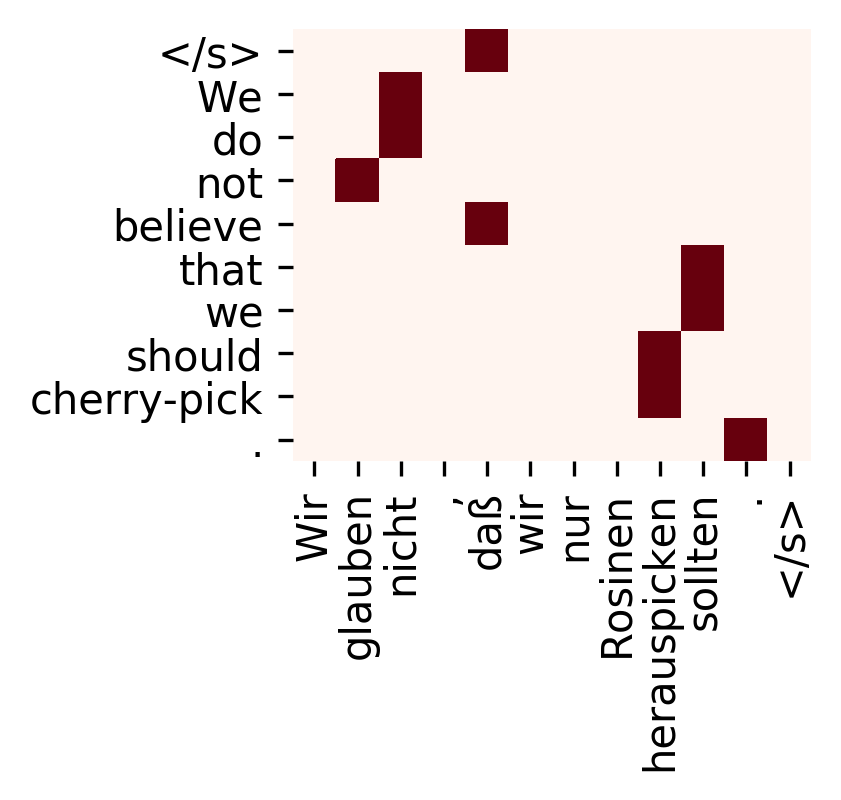

	gold:


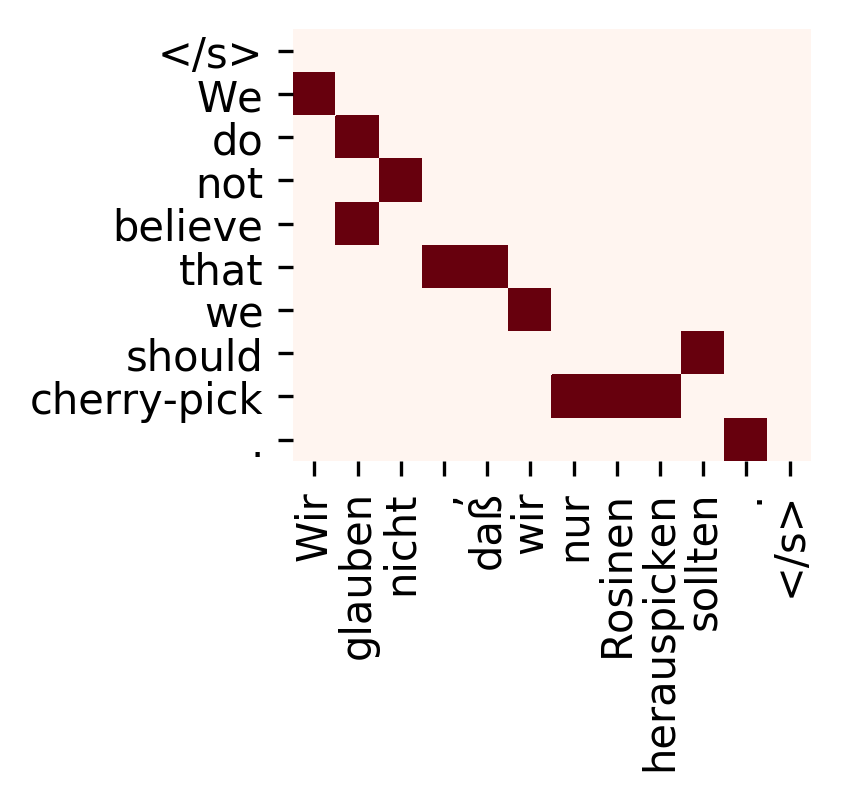

layer 4
	attn:


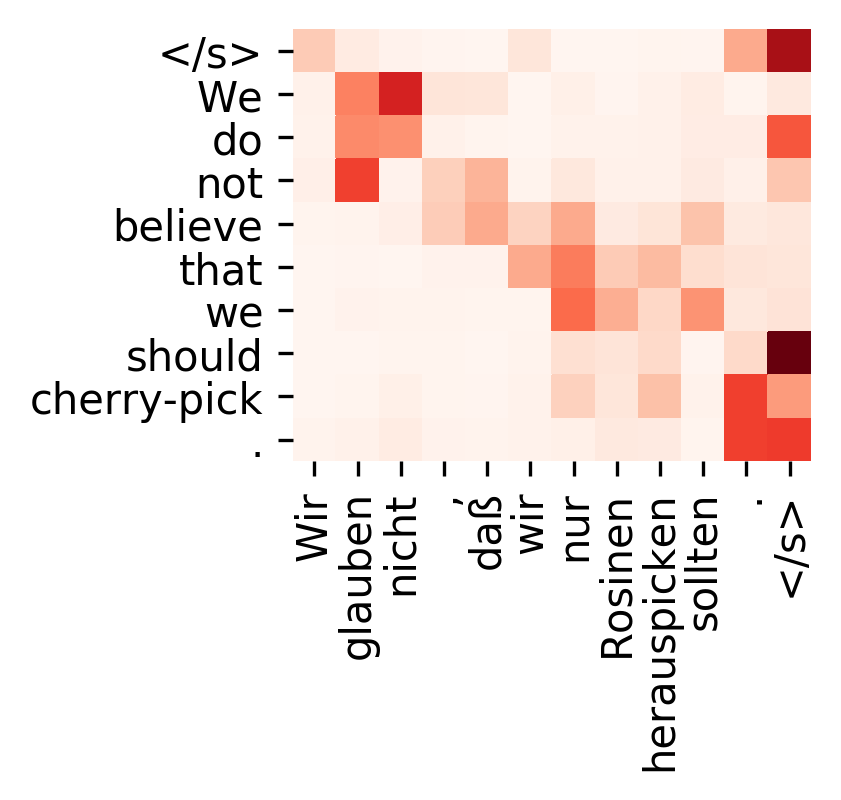

	summed_afx:


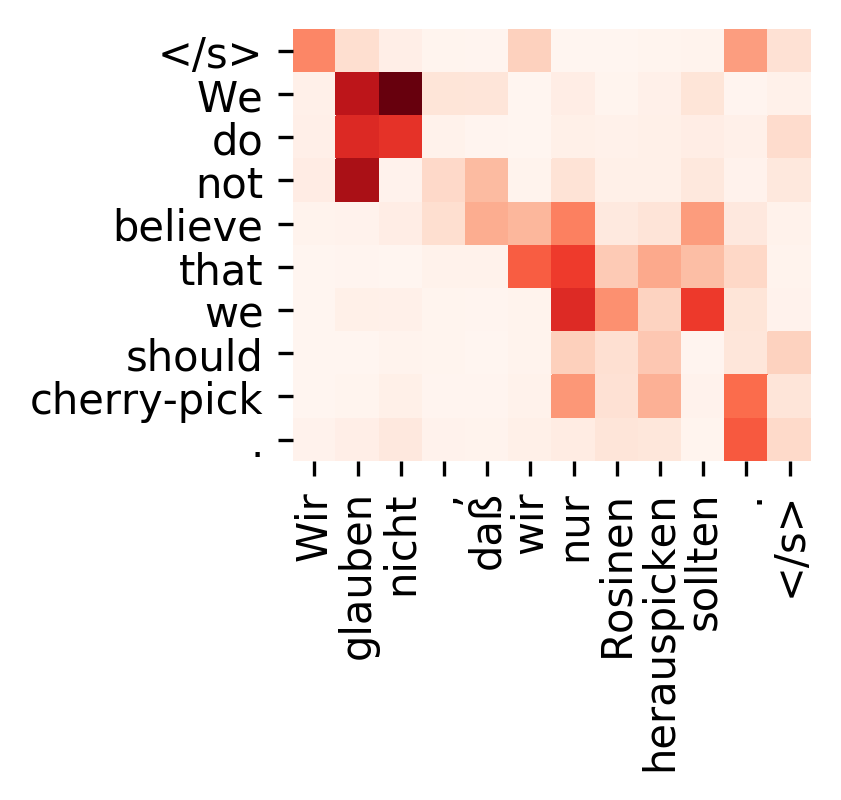

	attn:


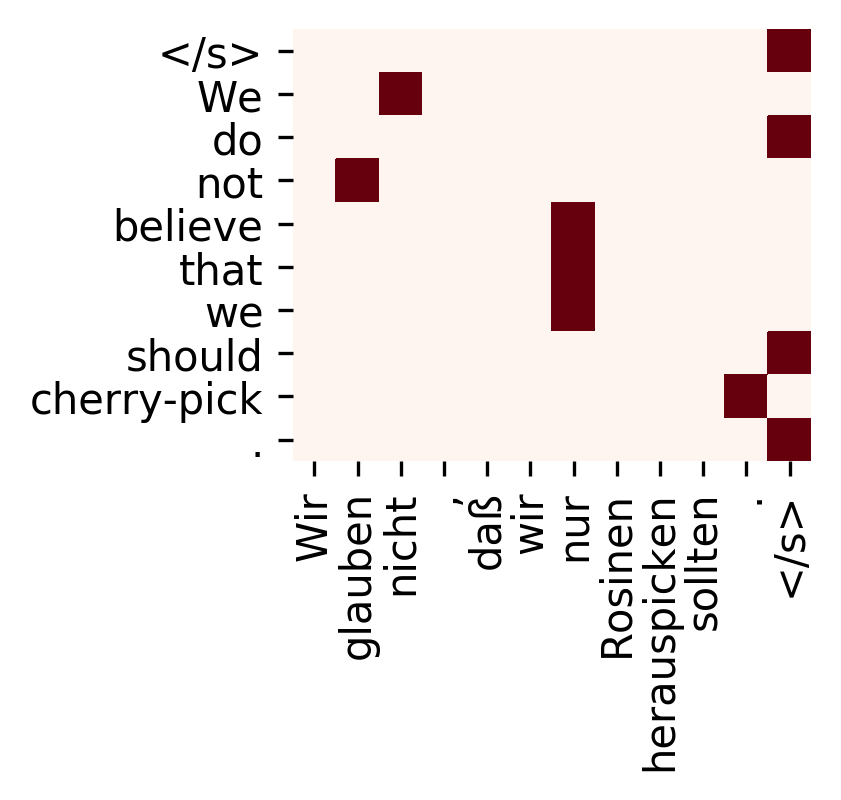

	summed_afx:


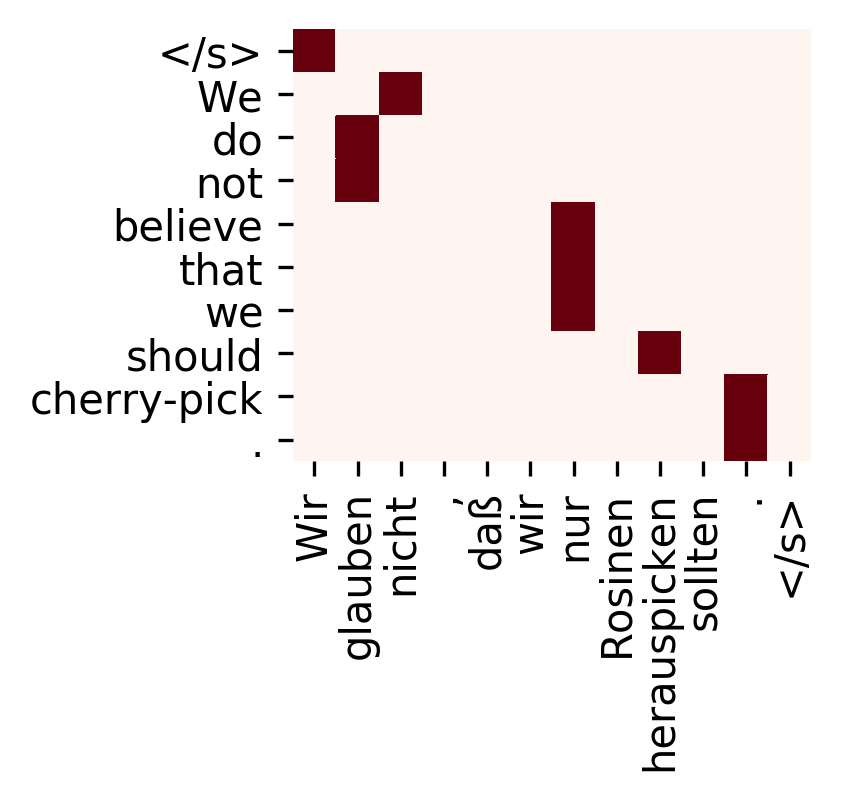

	gold:


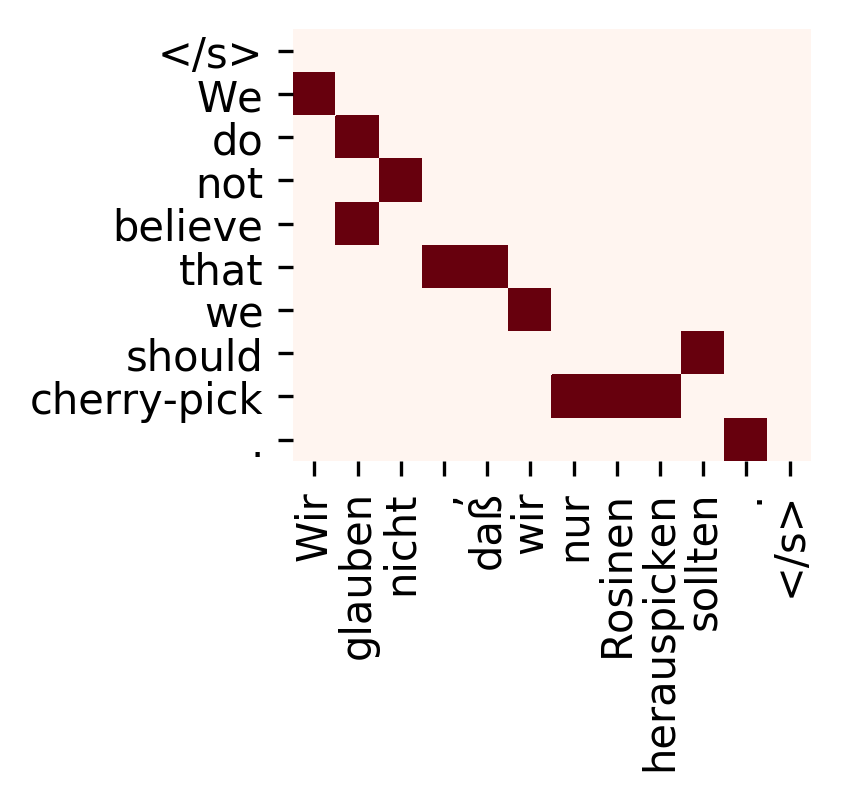

layer 5
	attn:


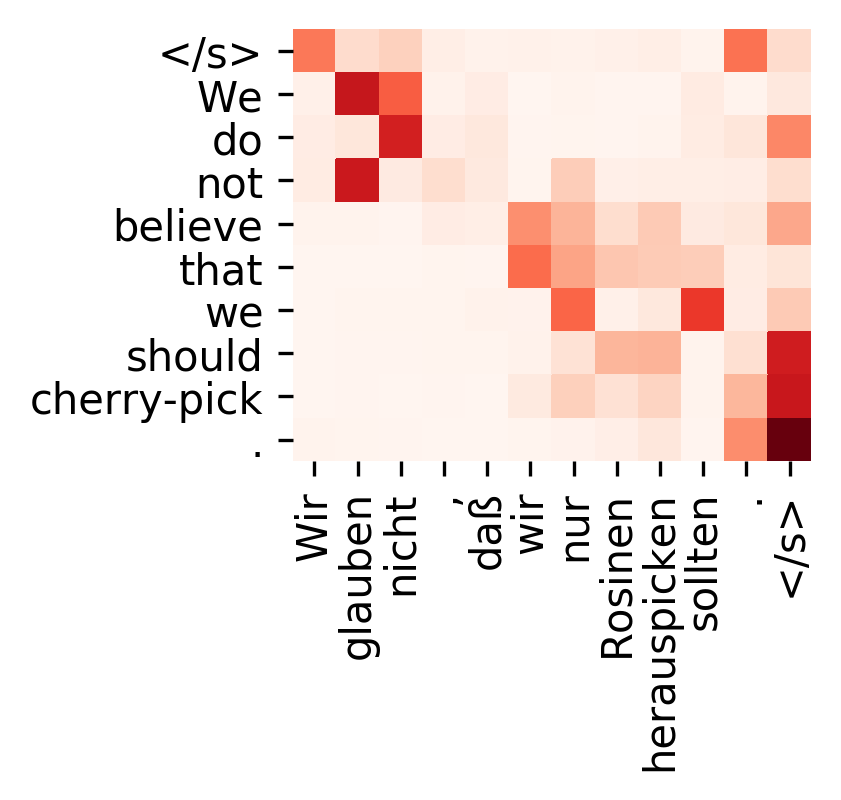

	summed_afx:


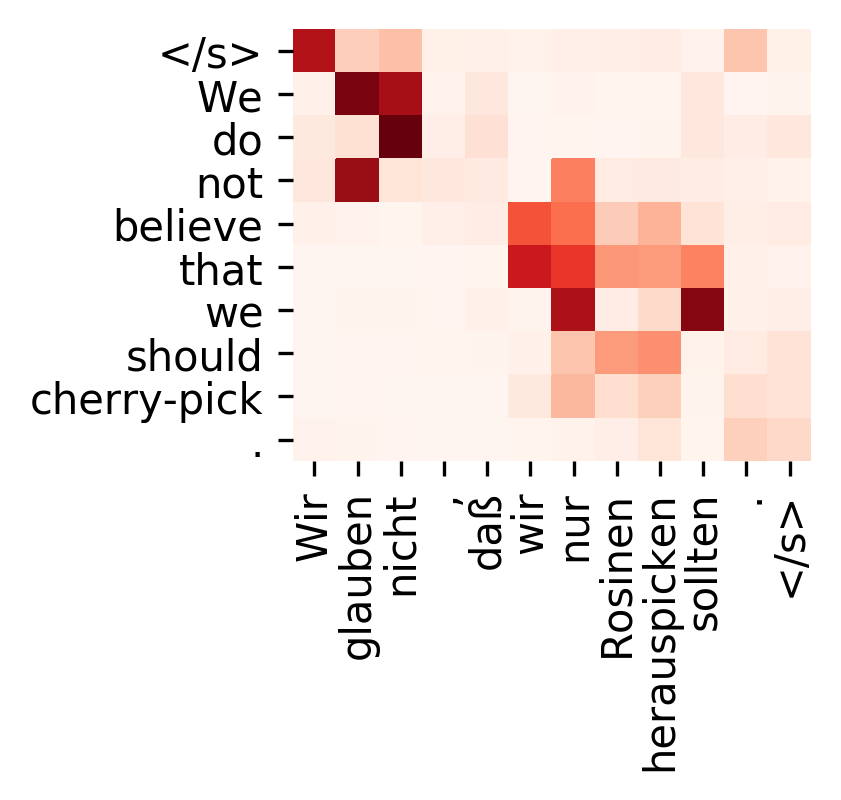

	attn:


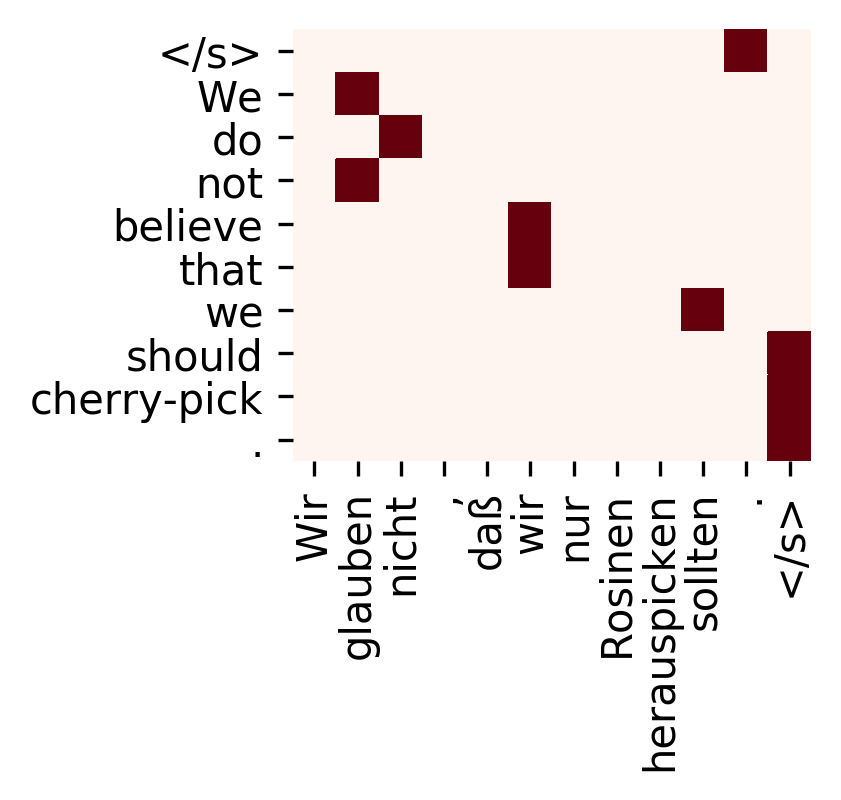

	summed_afx:


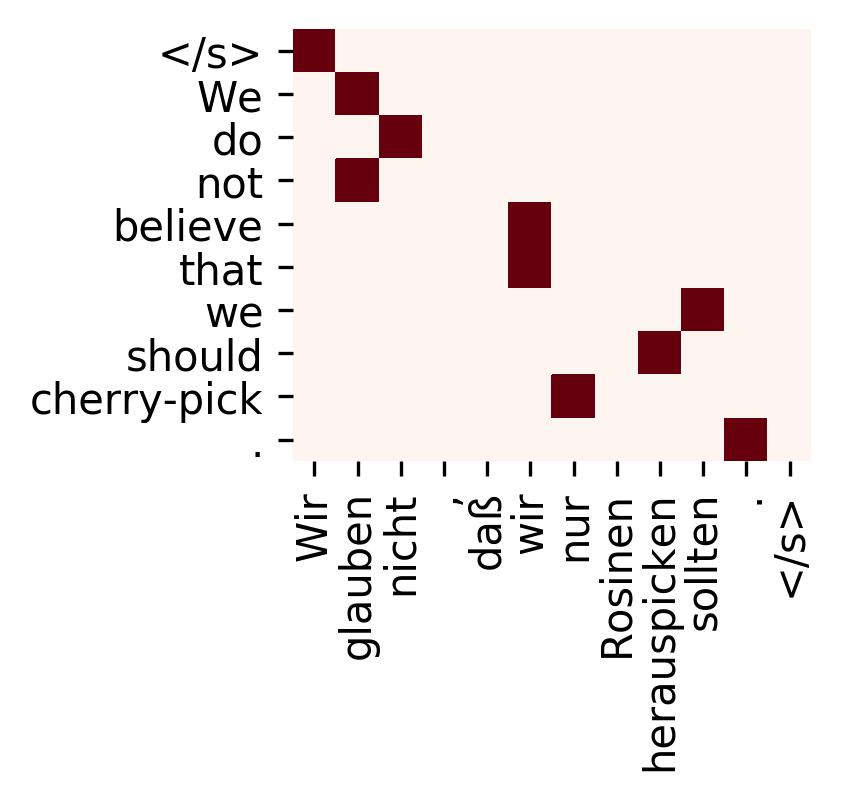

	gold:


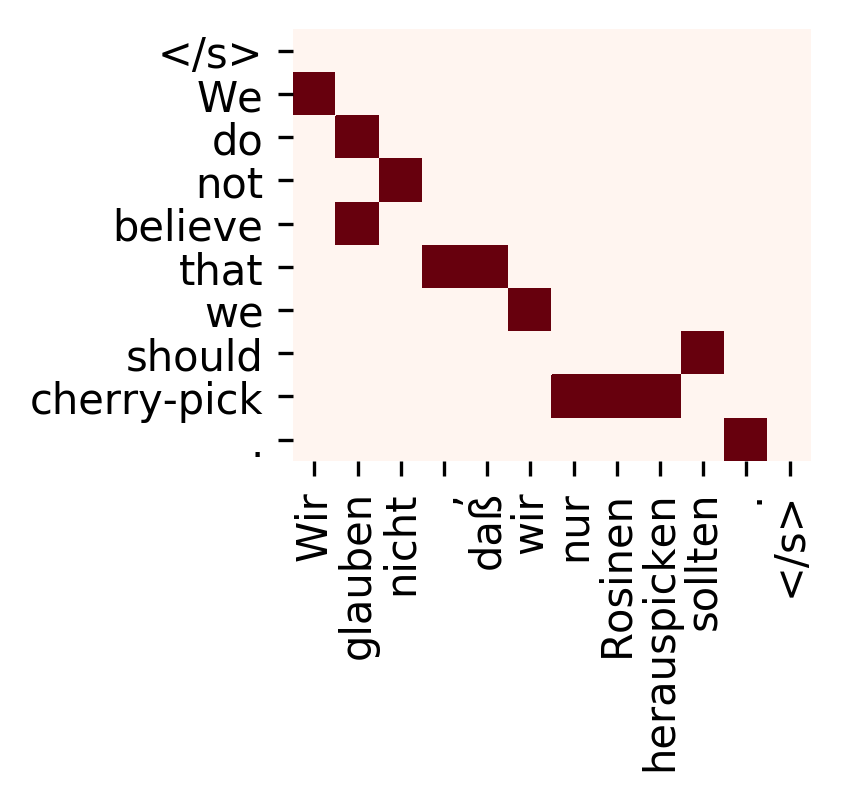

layer 6
	attn:


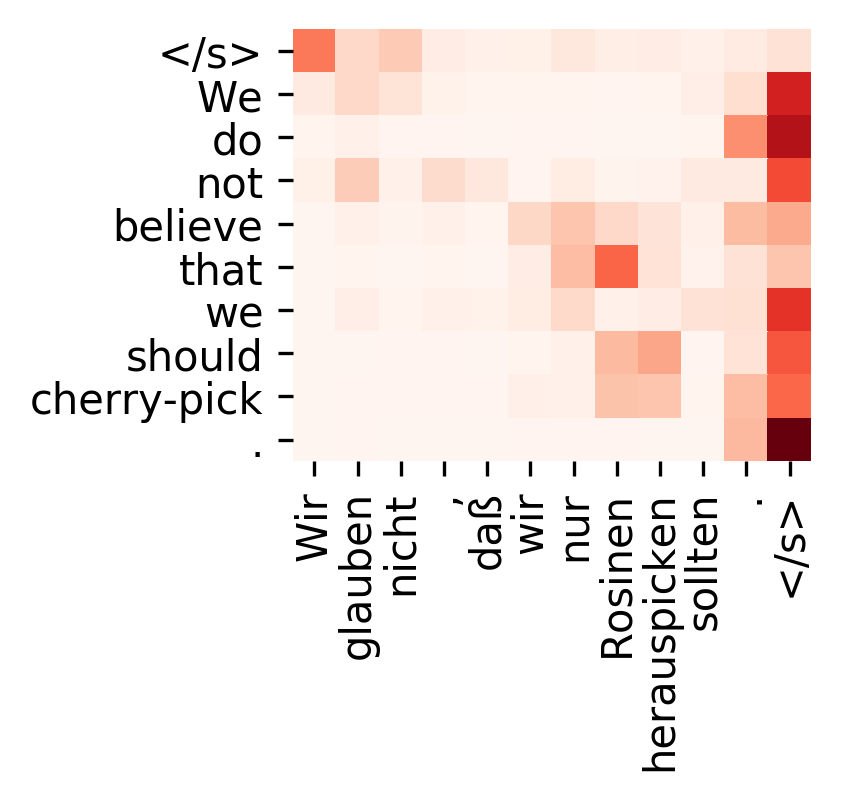

	summed_afx:


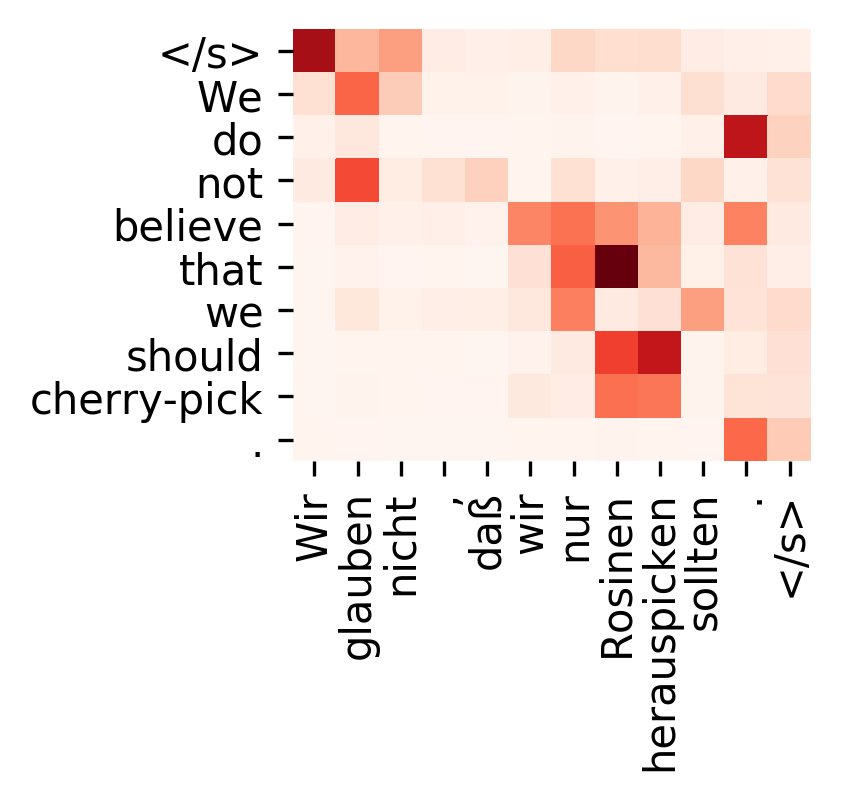

	attn:


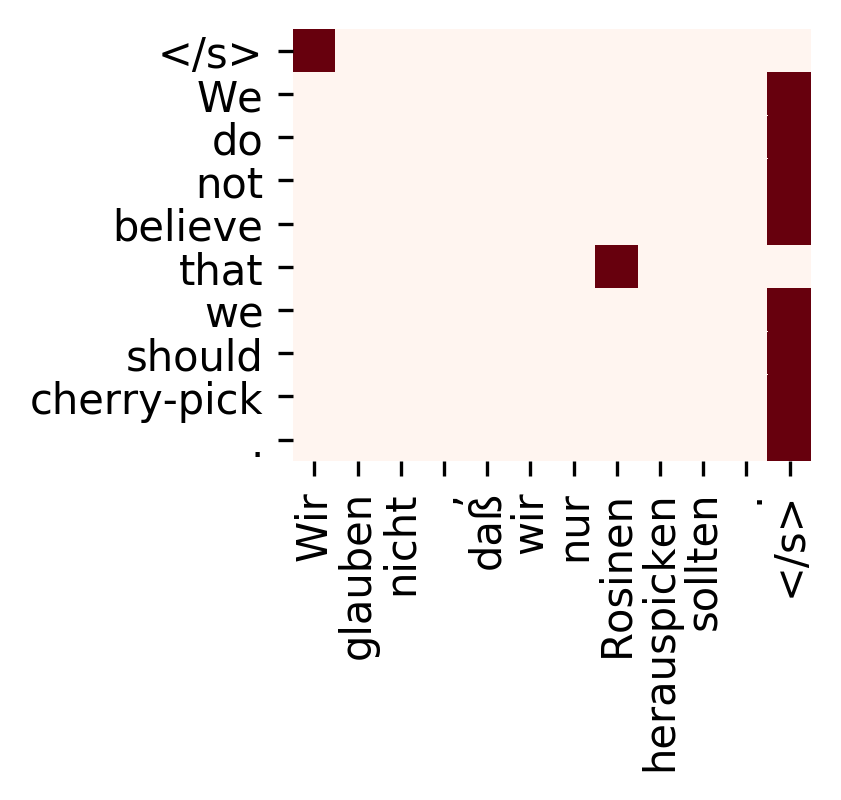

	summed_afx:


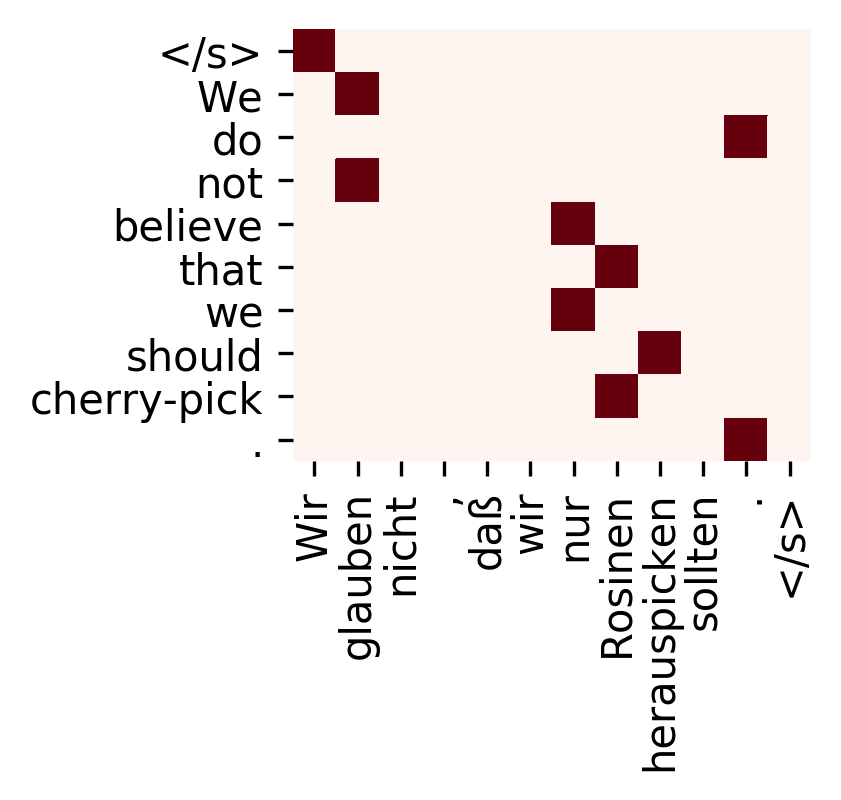

	gold:


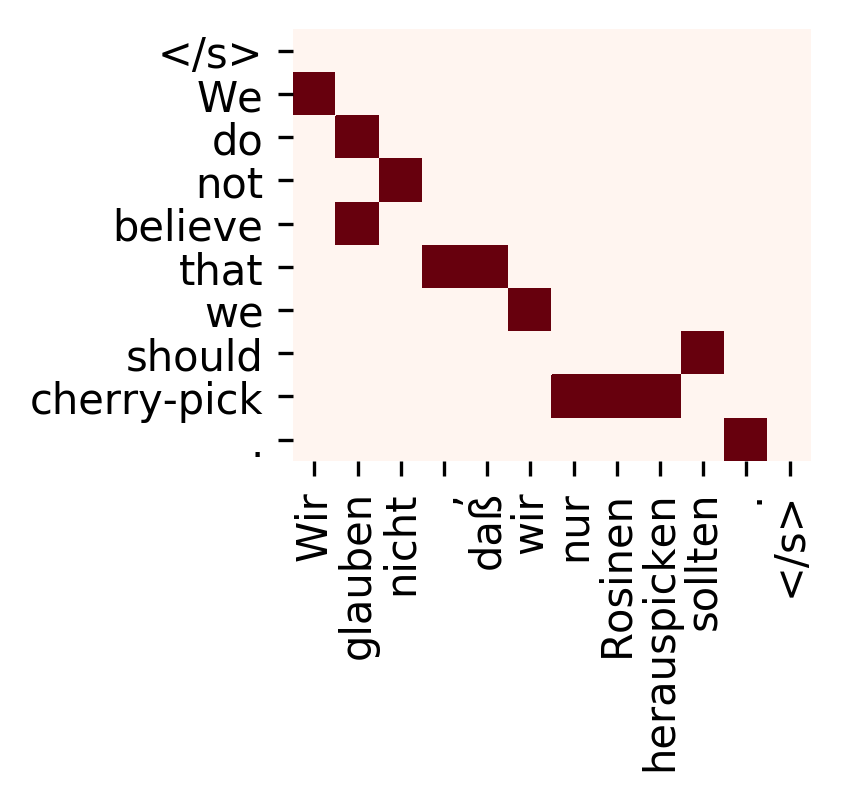

In [6]:
idx = 0 # select from 0~507
seed = 5498 # select from (2253, 5498, 9819, 9240, 2453)

for layer in range(6):
    print("layer", layer+1)
    visualize_attn_pattern(layer, idx, seed, hard=False)
    visualize_attn_pattern(layer, idx, seed, hard=True)